In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from data import load_database_train
from preprocessing import InterpolateRawData
from train import grid_search, scikit_train_validate
from sklearn.model_selection import cross_val_score
from cross_validation import cv_folds_author
import numpy as np
from plotter import plot_all_readings


%matplotlib inline

In [2]:
database_train = load_database_train()
X_processed = InterpolateRawData(num_samples=40).fit_transform(database_train.X)

# Modelo Base

## Analisando quantidade de amostragem na interpolação dos dados 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   16.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   21.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   43.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   57.7s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done  78 out of  80 | elapsed:  4.7min remaining:    7.2s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:  4.7min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'interpolate__num_samples': 5},0.94,0.03,0.65,0.15
1,{'interpolate__num_samples': 10},1.00,0.00,0.65,0.12
2,{'interpolate__num_samples': 20},1.00,0.00,0.68,0.14
3,{'interpolate__num_samples': 40},1.00,0.00,0.71,0.14
4,{'interpolate__num_samples': 80},1.00,0.00,0.70,0.14
5,{'interpolate__num_samples': 120},1.00,0.00,0.70,0.15
6,{'interpolate__num_samples': 240},1.00,0.00,0.70,0.14
7,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 10}",1.00,0.00,0.49,0.20
8,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 50}",1.00,0.00,0.48,0.20
9,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 100}",1.00,0.00,0.46,0.20


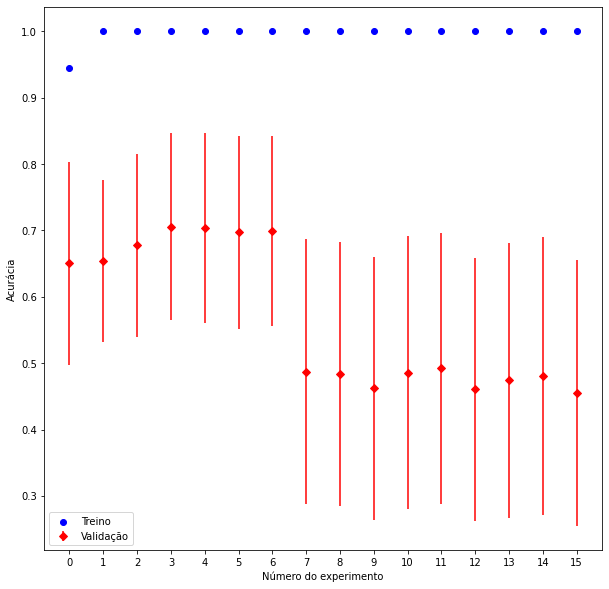

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,{'interpolate__num_samples': 40},1.00,0.00,0.71,0.14


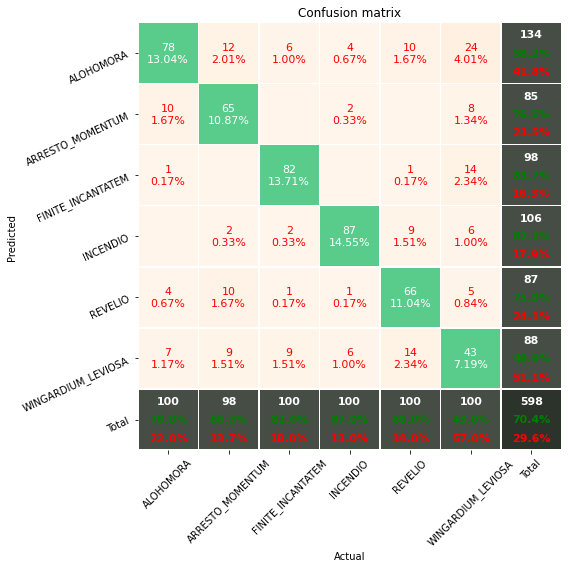

Pipeline(steps=[('interpolate', InterpolateRawData(num_samples=40)),
                ('logistic',
                 LogisticRegression(max_iter=100000, random_state=0))])

In [3]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData()),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

parameters = [
    {'interpolate__num_samples': [5, 10, 20, 40, 80, 120, 240]},
    
    {'interpolate__num_samples': [None], 
     'interpolate__timestep': [10, 50, 100], 
     'interpolate__max_time': [6000, 5000, 4000] 
    }
]

grid_search(pipe, parameters, database_train.X, database_train.y, database_train.cv_author, n_jobs=6)

Segundo modelo base de **Regressão Logistica**, o num_samples = 80 trouxe bons resultados, e maiores amostragens não trouxeram mudanças significativas. Nosso método grid_search já faz o Kfold considerando como divisaão de dados os autores (**cv_folds_author**)

Olhando os scores abaixo, percebemos como houve muita variação entre os folds, visto que cada fold é um autor com celular diferente que não tem no modelo.

In [4]:
pipe = Pipeline([
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

print(cross_val_score(pipe, X_processed, database_train.y, cv=database_train.cv_author))

[0.49166667 0.80833333 0.875      0.58333333 0.76271186]


Se não usassemos este método, e os dados fossem misturado, o resultado do modelo seria muito enviesado como abaixo, onde manteve uma boa acurácia acima dos 84% em todos os folds

In [5]:
print(cross_val_score(pipe, X_processed, database_train.y, cv=5))

[0.88333333 0.89166667 0.89166667 0.90756303 0.84033613]


# Random Forest

### Encontrando melhores parametros
criterion = Função para mensurar a qualidade da divisão
max_depth = Quando None os nós são expandidos até todas as folhas serem puras ou conterem o min_samples_split
bootstrap = se falso o dataset inteiro é usado para construir cada arvore \
n_estimators = número de arvores na floresta \
max_features = número de features utilizados na busca pela melhor amostragem (como o numero é float, estamos passando uma porcentagem do total de features \
min_samples_leaf = número mínimo de exemplos que são folhas nas arvores \
min_samples_split = Número minimo de exemplos obrigatórios para um nó interno \

dict_keys(['memory', 'steps', 'verbose', 'random', 'random__bootstrap', 'random__ccp_alpha', 'random__class_weight', 'random__criterion', 'random__max_depth', 'random__max_features', 'random__max_leaf_nodes', 'random__max_samples', 'random__min_impurity_decrease', 'random__min_impurity_split', 'random__min_samples_leaf', 'random__min_samples_split', 'random__min_weight_fraction_leaf', 'random__n_estimators', 'random__n_jobs', 'random__oob_score', 'random__random_state', 'random__verbose', 'random__warm_start'])
Fitting 5 folds for each of 630 candidates, totalling 3150 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.3s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   18.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   37.5s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   49.9s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  3.7min
[Parallel(

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 3, 'random__n_estimators': 80}",0.97,0.01,0.70,0.20
1,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 3, 'random__n_estimators': 90}",0.97,0.01,0.70,0.20
2,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 3, 'random__n_estimators': 100}",0.97,0.01,0.71,0.19
3,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 3, 'random__n_estimators': 110}",0.97,0.01,0.71,0.20
4,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 3, 'random__n_estimators': 130}",0.97,0.01,0.71,0.20
5,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5, 'random__n_estimators': 80}",0.97,0.01,0.71,0.20
6,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5, 'random__n_estimators': 90}",0.97,0.02,0.69,0.21
7,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5, 'random__n_estimators': 100}",0.97,0.01,0.69,0.20
8,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5, 'random__n_estimators': 110}",0.97,0.01,0.71,0.21
9,"{'random__bootstrap': False, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5, 'random__n_estimators': 130}",0.97,0.01,0.69,0.19


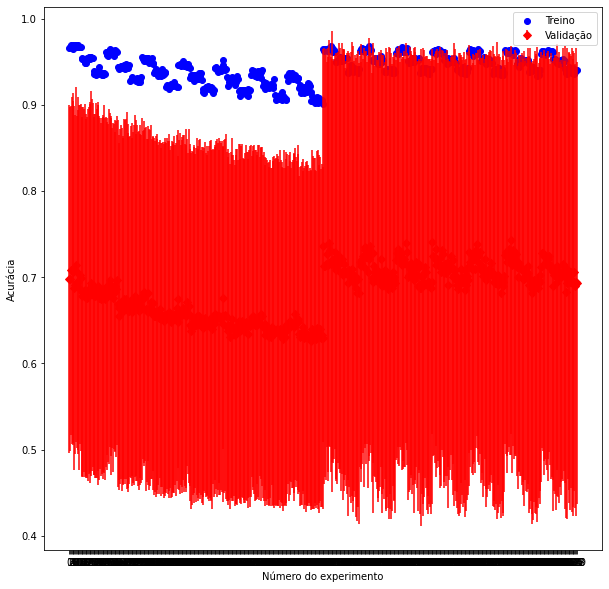

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
547,"{'random__bootstrap': True, 'random__max_features': 0.78, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5, 'random__n_estimators': 100}",0.96,0.02,0.74,0.23


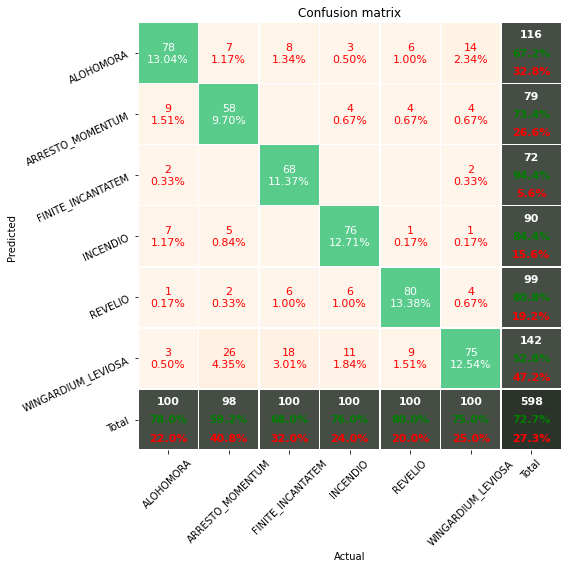

Pipeline(steps=[('random',
                 RandomForestClassifier(max_features=0.78, min_samples_leaf=10,
                                        min_samples_split=5))])

In [17]:
pipe = Pipeline([
    ('random', RandomForestClassifier(criterion='gini', max_depth=None))
])

print(pipe.get_params().keys())

parameters = {'random__bootstrap': [False, True],
         'random__n_estimators': [80,90, 100, 110, 130],
         'random__max_features': [0.6, 0.65, 0.7, 0.73, 0.7500000000000001, 0.78, 0.8],
         'random__min_samples_leaf': [10, 12, 14],
         'random__min_samples_split': [3, 5, 7]
        }
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vemos que uma tendencia do learning rate baixo, possuir um resultado dinals melhor, apesar das diferenças não significativas para learning_rate < 0.01, vamos adotar 0.0001 como padrão se o mesmo não causar tempo muito grande no aprendizado.

### Testando diferentes funções de ativação

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   22.0s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:   43.0s remaining:   28.7s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:   52.0s remaining:   17.3s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:   53.5s remaining:    5.9s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   55.7s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__activation': 'identity'},1.00,0.00,0.74,0.16
1,{'mlp__activation': 'logistic'},1.00,0.00,0.76,0.16
2,{'mlp__activation': 'tanh'},1.00,0.00,0.79,0.14
3,{'mlp__activation': 'relu'},1.00,0.00,0.75,0.17


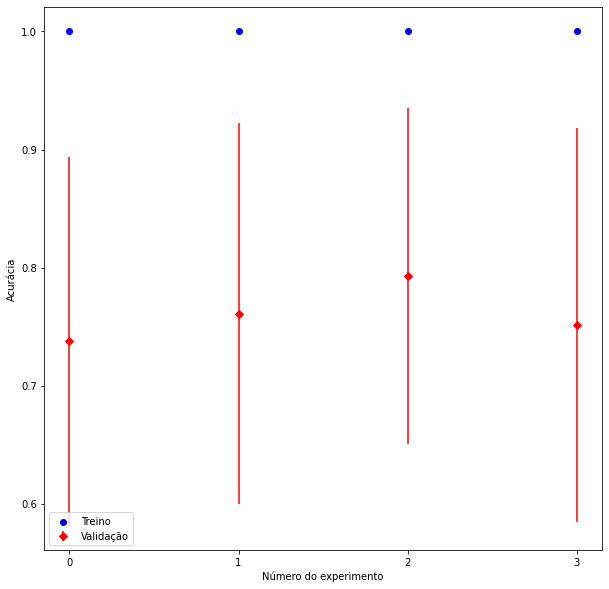

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
2,{'mlp__activation': 'tanh'},1.00,0.00,0.79,0.14


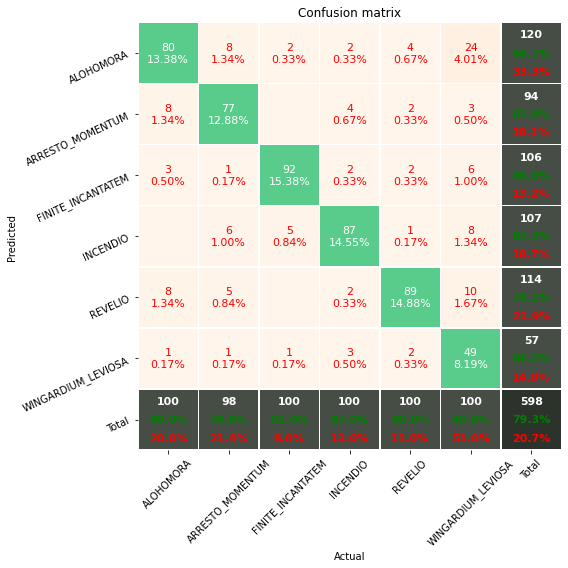

Pipeline(steps=[('mlp',
                 MLPClassifier(activation='tanh', learning_rate_init=0.0001,
                               max_iter=100000, random_state=0))])

In [7]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

parameters = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu']}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Não conseguimos notar diferenças significaticas na função de ativação, a 'relu' parece ser levemente melhor, vamos adota-la como padrão (já é o padrão da biblioteca)

### Testando diferentes batch-size

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   18.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   32.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   55.6s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  95 out of  95 | elapsed:  3.5min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__batch_size': 10},1.00,0.00,0.76,0.17
1,{'mlp__batch_size': 20},1.00,0.00,0.76,0.17
2,{'mlp__batch_size': 30},1.00,0.00,0.76,0.17
3,{'mlp__batch_size': 40},1.00,0.00,0.75,0.17
4,{'mlp__batch_size': 50},1.00,0.00,0.75,0.17
5,{'mlp__batch_size': 60},1.00,0.00,0.75,0.17
6,{'mlp__batch_size': 70},1.00,0.00,0.75,0.17
7,{'mlp__batch_size': 80},1.00,0.00,0.75,0.16
8,{'mlp__batch_size': 90},1.00,0.00,0.75,0.16
9,{'mlp__batch_size': 100},1.00,0.00,0.76,0.16


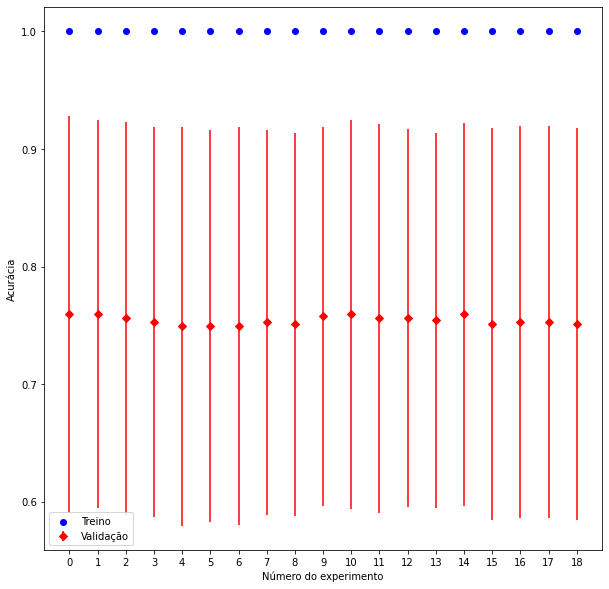

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__batch_size': 10},1.00,0.00,0.76,0.17


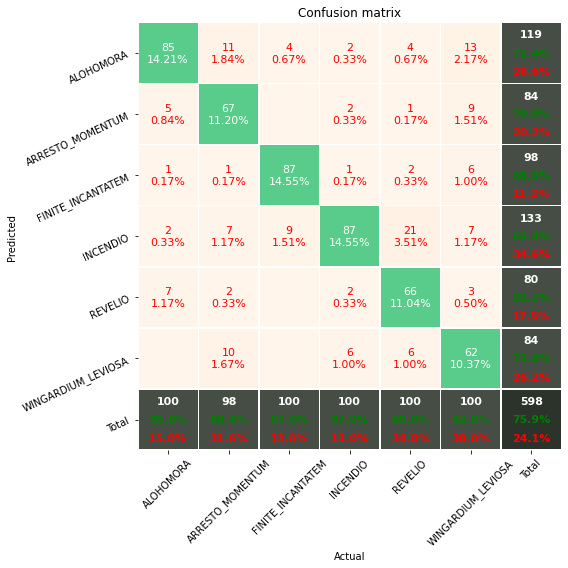

Pipeline(steps=[('mlp',
                 MLPClassifier(batch_size=10, learning_rate_init=0.0001,
                               max_iter=100000, random_state=0))])

In [8]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

parameters = {'mlp__batch_size': np.arange(10, 200, 10)}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Sem diferenças no batch-size, vamos usar o padrao do scikit-learn que é 200

### Testando Scalers

train_scores:     ['1.00', '1.00', '1.00', '1.00', '1.00'] 
mean_train_score: 1.00
std_train_score:  0.00


test_scores:      ['0.43', '0.83', '0.93', '0.72', '0.81']
mean_test_score:  0.75
std_test_score:   0.17


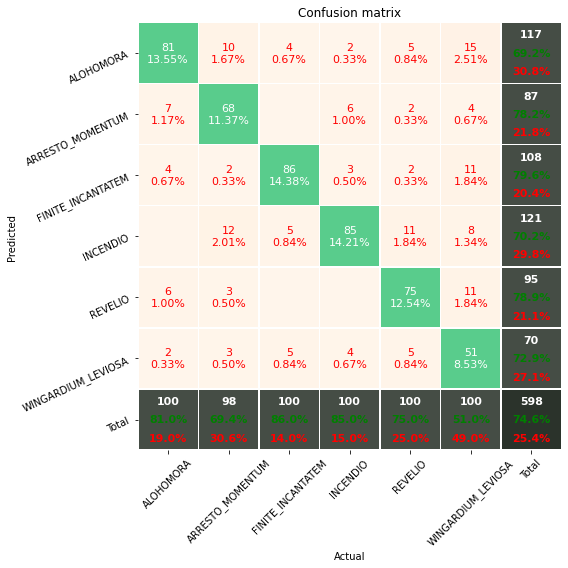

In [9]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

scikit_train_validate(pipe, X_processed, database_train.y, database_train.cv_author)

train_scores:     ['1.00', '1.00', '1.00', '1.00', '1.00'] 
mean_train_score: 1.00
std_train_score:  0.00


test_scores:      ['0.42', '0.84', '0.94', '0.80', '0.80']
mean_test_score:  0.76
std_test_score:   0.18


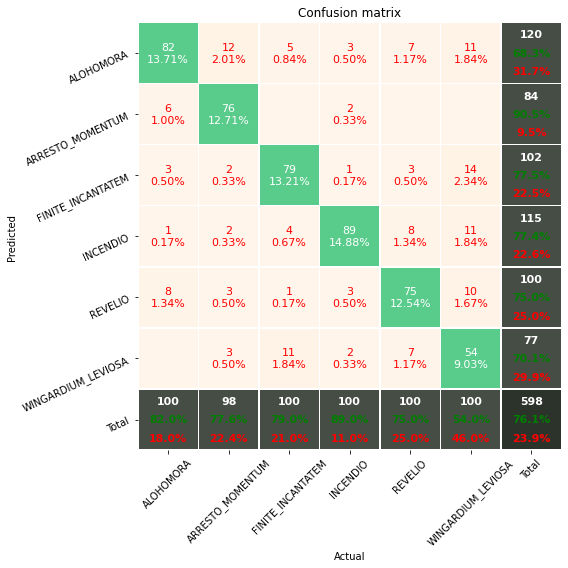

In [10]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

scikit_train_validate(pipe, X_processed, database_train.y, database_train.cv_author)

Vemos que o método StandardScaler, melhorou razoavelmente o modelo, isso pode ser explicado pois dados do Giroscopio e Acelerometro não estão na mesma escala, como pode ser visto nesse exemplo:

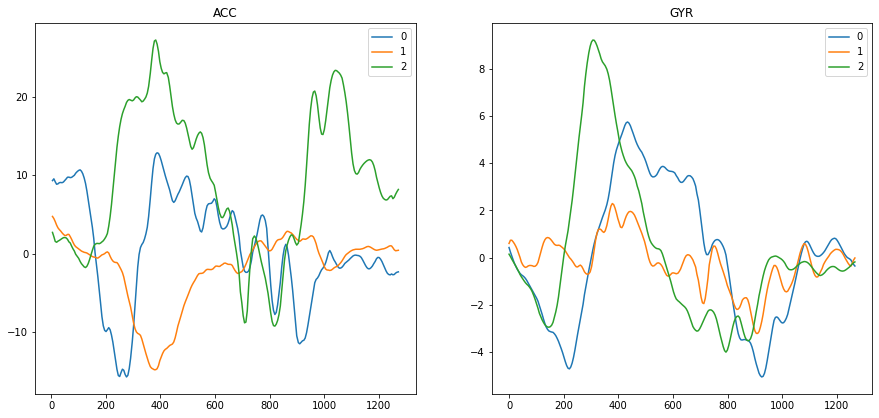

In [11]:
plot_all_readings(database_train.datalist[0].readings, table_format=(0, 2))

### Testando regularização l2

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   23.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   31.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done  39 out of  45 | elapsed:  3.4min remaining:   31.0s
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:  3.7min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__alpha': 1},1.00,0.00,0.77,0.17
1,{'mlp__alpha': 10},0.99,0.00,0.79,0.17
2,{'mlp__alpha': 50},0.92,0.03,0.79,0.18
3,{'mlp__alpha': 60},0.90,0.04,0.79,0.18
4,{'mlp__alpha': 70},0.90,0.04,0.77,0.18
5,{'mlp__alpha': 80},0.88,0.04,0.77,0.17
6,{'mlp__alpha': 100},0.86,0.05,0.75,0.16
7,{'mlp__alpha': 150},0.72,0.09,0.61,0.11
8,{'mlp__alpha': 200},0.60,0.07,0.55,0.09


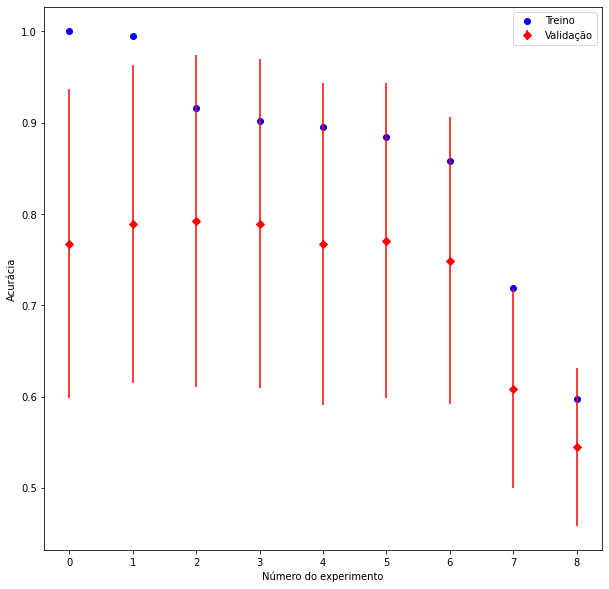

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
2,{'mlp__alpha': 50},0.92,0.03,0.79,0.18


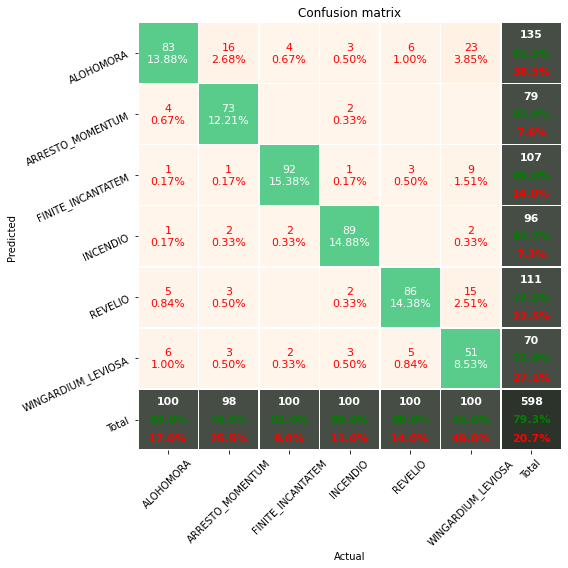

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=50, learning_rate_init=0.0001,
                               max_iter=100000, random_state=0))])

In [12]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001))
])

parameters = {'mlp__alpha': [1, 10, 50, 60, 70, 80, 100, 150, 200]}

grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vimos que agora um alpha de 60 melhorou suavemente o modelo na validação e deixou com menos overfit

### Early-stop

In [13]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001,
                          alpha=60, early_stopping=True))
])

parameters = {'mlp__n_iter_no_change': np.arange(100, 2000, 100)}

grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   12.6s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   53.1s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  3.6min


KeyboardInterrupt: 

Vimos que o método early_stopping não trouxe beneficios ao modelo.

### Numero de neuronios

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001, alpha=60))
])
 
parameters = {'mlp__hidden_layer_sizes': [(10,), (100,), (500,), (1000,)]}
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001, alpha=60))
])
 
parameters = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (50, 10), (100, 20), (200, 40)]}
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, learning_rate_init=0.0001, alpha=60))
])
 
parameters = {
    'mlp__alpha': [1, 10, 60],
    'mlp__hidden_layer_sizes': [(50, 10), (100, 20), (200, 40)]}
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Aparentemete as redes neurais ficaram piores com o aumento do numero de camadas